<a href="https://colab.research.google.com/github/Kontrabass2018/DeepLearningGPU/blob/main/GPU_computing_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [1]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.8.2 on the current Colab Runtime...
2024-12-13 07:58:45 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.2-linux-x86_64.tar.gz [135859273/135859273] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing Julia package CUDA...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.8

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [6]:
versioninfo()

NameError: name 'versioninfo' is not defined

In [ ]:
using BenchmarkTools

M = rand(2^11, 2^11)

@btime $M * $M;

  470.139 ms (2 allocations: 32.00 MiB)


In [ ]:
# only first time!
using Pkg
Pkg.add("CUDA")
Pkg.add("Flux")
Pkg.add("HDF5")


  ✓ SentinelArrays
  ✓ DataValueInterfaces
  ✓ LaTeXStrings
  ✓ InvertedIndices
  ✓ Reexport
  ✓ ExprTools
  ✓ IteratorInterfaceExtensions
  ✓ DataAPI
  ✓ FixedPointNumbers
  ✓ BFloat16s
  ✓ UnsafeAtomics
  ✓ Crayons
  ✓ Scratch
  ✓ CEnum
  ✓ RandomNumbers
  ✓ CUDA_Runtime_Discovery
  ✓ StaticArraysCore
  ✓ MacroTools
  ✓ JuliaNVTXCallbacks_jll
  ✓ NVTX_jll
  ✓ LLVMExtra_jll
  ✓ StringManipulation
  ✓ CUDA_Runtime_jll
  ✓ InlineStrings
  ✓ Adapt
  ✓ ChainRulesCore
  ✓ TableTraits
  ✓ TimerOutputs
  ✓ PooledArrays
  ✓ DataStructures
  ✓ Missings
  ✓ Atomix
  ✓ Random123
  ✓ ColorTypes
  ✓ EnzymeCore
  ✓ GPUArraysCore
  ✓ AbstractFFTs
  ✓ Tables
  ✓ LLVM
  ✓ SortingAlgorithms
  ✓ StaticArrays
  ✓ Colors
  ✓ GPUArrays
  ✓ KernelAbstractions
  ✓ NVTX
  ✓ GPUCompiler
  ✓ PrettyTables
  ✓ DataFrames
  ✓ CUDA
  53 dependencies successfully precompiled in 182 seconds. 21 already precompiled.
   Resolving package versions...
   Installed IrrationalConstants ──── v0.2.2
   Installed GPUArraysCor

In [ ]:
using CUDA
using Flux


## Importing Data

In [ ]:
using Random
function load_tcga_data(infilename; shfl = true)
    infile = h5open(infilename)
    TCGA_data = infile["data"][:,:]
    labs = string.(infile["labels"][:])
    samples = string.(infile["samples"][:])
    genes = string.(infile["genes"][:])
    biotypes = string.(infile["biotypes"][:])
    close(infile)
    ids = collect(1:size(labs)[1])
    shfl && (ids = shuffle(ids))
    return TCGA_data[ids,:], labs[ids], samples[ids], genes, biotypes
end

function fetch_data(filename; shfl = true)
    if !(filename in readdir("."))
        # Define the URL`
        tcga_data_url = "https://bioinfo.iric.ca/~sauves/VARIA/$filename"

        # Escape the URL to handle special characters
        escaped_url = Base.shell_escape(tcga_data_url)

        # Construct and execute the wget command
        command = `wget $escaped_url`
        run(command)
    end
    load_tcga_data(filename; shfl = shfl)

end

fetch_data (generic function with 1 method)

In [ ]:

using HDF5


   Resolving package versions...


LoadError: InterruptException:

In [ ]:
infilename = "TCGA_TPM_lab.h5"
TCGA_data, labels, samples, genes, biotypes = fetch_data(infilename)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 83600K .......... .......... .......... .......... ..........  1% 86.0M 2m25s
 83650K .......... .......... .......... .......... ..........  1%  119M 2m25s
 83700K .......... .......... .......... .......... ..........  1% 59.7M 2m25s
 83750K .......... .......... .......... .......... ..........  1% 78.8M 2m25s
 83800K .......... .......... .......... .......... ..........  1% 34.8M 2m25s
 83850K .......... .......... .......... .......... ..........  1%  118M 2m25s
 83900K .......... .......... .......... .......... ..........  1%  110M 2m24s
 83950K .......... .......... .......... .......... ..........  1%  127M 2m24s
 84000K .......... .......... .......... .......... ..........  1% 78.3M 2m24s
 84050K .......... .......... .......... .......... ..........  1%  116M 2m24s
 84100K .......... .......... .......... .......... ..........  1%  120M 2m24s
 84150K .......... .......... .......... .......... .

LoadError: UndefVarError: shuffle not defined

# Coding an SVD implementation in Julia on GPU

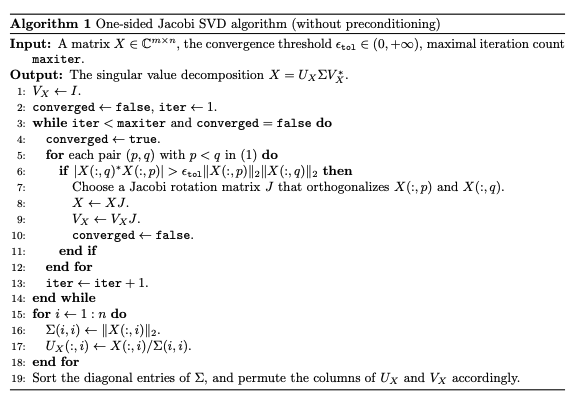

SVD algorithm as presented in this article https://arxiv.org/pdf/2209.04626

# Need Help?

* Learning: https://julialang.org/learning/
* Documentation: https://docs.julialang.org/
* Questions & Discussions:
  * https://discourse.julialang.org/
  * http://julialang.slack.com/
  * https://stackoverflow.com/questions/tagged/julia

If you ever ask for help or file an issue about Julia, you should generally provide the output of `versioninfo()`.

Add new code cells by clicking the `+ Code` button (or _Insert_ > _Code cell_).

Have fun!

<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />